
# What features determine the price of an Airbnb rental?

In [2]:
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns
import sklearn.metrics       as Metrics
import pandas                as pd
import matplotlib.pyplot     as plt


import folium  #needed for interactive map
from folium.plugins import HeatMap

from   collections           import Counter
from   sklearn               import preprocessing
from   datetime              import datetime
from   collections           import Counter
from   math                  import exp
from   sklearn.linear_model  import LinearRegression as LinReg
from   sklearn.metrics       import mean_absolute_error
from   sklearn.metrics       import median_absolute_error
from   sklearn.metrics       import r2_score

%matplotlib inline
sns.set()

## Introduction (10 mts)

**Business Context**. Airbnb is an enormous online marketplace for everyday people to rent places to stay. It is a large and lucrative market, but many vendors are simply individuals who are renting their own primary residence for short visits. Even larger vendors are typically small businesses with only a small number of places to rent. As a result, they have limited ability to assess large-scale trends and set optimal prices.

Airbnb has rolled out a new service to help listers set prices. Airbnb makes a percentage commission off of the listings, so they are incentivized to help listers price optimally; that is, at the maximum possible point where they will still close a deal. You are an Airbnb consultant helping with this new pricing service.

**Business Problem**. Your initial task is to explore the data with the goal of answering the question: <b>"What features are most relevant to the price of an Airbnb listing?"</b>

**Analytical Context**. We will use the publicly available and well-maintained dataset created by the Inside Airbnb advocacy group. We will focus on listings in New York City within the last year, taking advantage of larger datasets when there are important details to explore.

The case is structured as follows: we will (1) do basic data exploration by plotting distributions of key quantities; (2) introduce the concept of correlation to find the key features; (3) introduce the idea of interaction effects to correct for the effects of key features; (4) discuss how to iteratively generate hypotheses and choose data visualizations to support your conclusions; (5) look at one very specific type of interaction effect, the temporal effect, and how to correct for it; and finally (6) pull everything together to identify the key factors that affect the price.

## Some basic data exploration (20 mts)

We begin by loading the data and looking at its basic shape:

In [5]:
listings = pd.read_csv('airbnb_NYC.csv', delimiter=',')
listings.shape

(30179, 81)

Let's also look at the columns of the dataset:

In [6]:
listings.columns 

Index(['id', 'name', 'summary', 'description', 'experiences_offered',
       'neighborhood_overview', 'transit', 'house_rules', 'host_id',
       'host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_identity_verified',
       'street', 'neighbourhood', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'guests_included', 'extra_people',
       'minimum_nights', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'calculated_host_listings_count',


In [4]:
# We display the basic listings data.
pd.options.display.max_columns = 100
listings.head(3)

,id,name,summary,description,experiences_offered,neighborhood_overview,transit,house_rules,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,street,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,check_in_24h,air_conditioning,high_end_electronics,bbq,balcony,nature_and_views,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,child_friendly,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,accessible,event_suitable
0,2539,Clean & quiet apt home by the park,Renovated apt home in elevator building.,Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,Very close to F and G trains and Express bus i...,-The security and comfort of all our guests is...,2787,39698.0,within an hour,1.0,0.0,6.0,1.0,"Brooklyn , NY, United States",Brooklyn,40.64749,-73.97237,Apartment,Private room,2,1.0,1,1,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",149,1,35,1,3 weeks ago,1,30,60,90,365,9,2,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,moderate,6,0,5,1,0.21,1,-1,-1,-1,-1,-1,1,-1,1,1,1,1,1,-1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,-1,1,1
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,NaN,Upon arrival please have a legibile copy of yo...,4632,39777.0,within a day,1.0,0.0,1.0,1.0,"New York, NY, United States",Harlem,40.80902,-73.94190,Apartment,Private room,2,1.0,1,1,Pull-out Sofa,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",150,2,20,3,34 months ago,1,30,60,90,365,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,strict_14_with_grace_period,1,0,1,0,NaN,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
2,7750,Huge 2 BR Upper East Cental Park,NaN,Large Furnished 2BR one block to Central Park...,none,NaN,NaN,NaN,17985,39953.0,within a day,1.0,0.0,2.0,1.0,"New York, NY, United States",Harlem,40.79685,-73.94872,Apartment,Entire home/apt,4,1.0,2,2,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",190,1,0,7,7 weeks ago,1,4,14,14,249,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,flexible,2,1,1,0,NaN,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,-1


The following are details about some of the important columns here:

1. ```neighbourhood```:  which neighborhood the property is in
2. ```longitude```, ```latitude```: longitude and latitude
3. ```property_type```: type of property, such as apartment, condo etc.
4. ```bathrooms```: number of bathrooms
5. ```bedrooms```: number of bathrooms
6. ```price```:  price of the listing
7. ```number_of_reviews```: number of reviews given by customers who stayed there
8. ```parking```: 1 means there is parking available, -1 means there is not

For other categorical variables, such as ```outdoor_friendly```, ```gym```, etc., the 1,-1 should be interpreted similarly to ```parking``` as explained above.

### Plotting the marginal distributions of key quantities of interest

As you have seen in the Python cases, it is good to first develop an idea of how the values of a few key quantities of interest are distributed. Let's start by doing so for some numeric variables, such as ```price```, ```bedrooms```, ```bathrooms```, ```number_of_reviews```:

### Exercise 1:

#### 1.1

Use the ```describe()``` and ```quantile()``` commands to compute some important summary statistics for the above variables.

#### 1.2

Use the ```plt.hist()``` function to plot the histogram of the above variables. What are their basic shapes (e.g. normal, skewed, multi-modal, etc.)?

#### 1.3

Are the distributions fairly smooth, or do they exhibit "spiky" or "discontinuous" behavior? If the latter, can you explain where it might come from?


#### 1.4 

Can you detect any outliers from these histograms? If so, do they suggest (i) data error; or (ii) data that should be omitted from our future analysis?


### Another way to look at the histogram of number of bedrooms

Sometimes, it is better to look at a histogram which plots the <i>relative</i> percentages of values across categories:

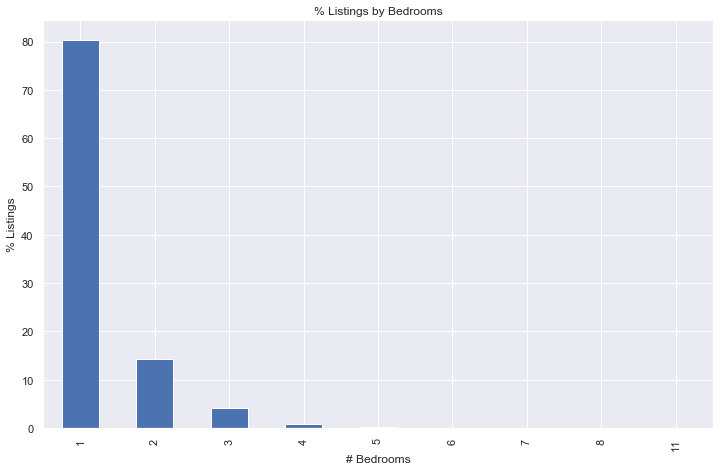

Percent of 1 Bedroom Listings: %80.37


In [9]:
# How many bedrooms
bedrooms_counts = Counter(listings.bedrooms)
tdf = pd.DataFrame.from_dict(bedrooms_counts, orient = 'index').sort_values(by = 0)
tdf = (tdf.iloc[-10:, :] / len(listings)) * 100

# Sort bedroom dataframe by number
tdf.sort_index(axis = 0, ascending = True, inplace = True)

# Plot percent of listings by bedroom number
ax = tdf.plot(kind = 'bar', figsize = (12, 7.5))
ax.set_xlabel("# Bedrooms")
ax.set_ylabel("% Listings")
ax.set_title('% Listings by Bedrooms')
ax.legend_.remove()

plt.show()

print("Percent of 1 Bedroom Listings: %{0:.2f}".format(tdf[0][1])) 
#The syntax 0:.2f denotes that we will print upto to decimal places
#Change it to %{0:.3f to see what happens}

## Inspecting price against variables of interest

Now that we have looked at the variables of interest in isolation, it makes sense to look at them in relation to price.

### Exercise 2:

#### 2.1
Write code for making a boxplot of ```price``` vs. ```bedrooms```, ```bathrooms```, ```number_of_reviews```, ```review_scores_cleanliness```.

#### 2.2

Comment on the relationship between price and the respective variable in each of the above plots.

### Investigating correlations (15 mts)

Although plotting the relationship between price and a few other variables is a good first step, overall there are too many variables to individually plot and manually inspect. We need a more systematic method. How do we proceed? An easy way to get a quick overview of the key variables that affect the price is via <b>correlation</b>.

Let's look at the ```price``` vs. ```bedrooms``` plot again:

Text(0.5, 1.0, 'Boxplot of Price vs. Bedrooms')

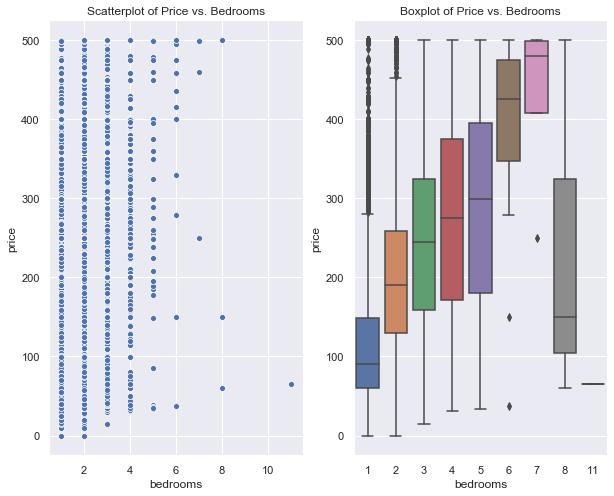

In [11]:
plt.figure(figsize=(10,8))
plt.subplot(121)
sns.scatterplot(x='bedrooms',y = 'price', data = listings)
plt.ylabel("price")
plt.title("Scatterplot of Price vs. Bedrooms")
plt.subplot(122)
sns.boxplot(x='bedrooms',y= 'price', data = listings)
plt.ylabel("price")
plt.title("Boxplot of Price vs. Bedrooms")

We see that as the number of bedrooms increases, the price on average increases. The quantity <b>correlation</b> is one way to capture this relationship. The correlation of two quantities is a measurement of how much they tend to increase together, measured on a scale going from -1 to 1. A positive correlation between price and number of bedrooms would indicate that higher-priced listings tend to have <i>more</i> bedrooms. Similarly, a negative correlation between price and number of bedrooms would indicate that higher-priced listings tend to have <i>fewer</i> bedrooms.  In our case, we can easily see that price is positively correlated with bedrooms.

Since correlation is just a single number summarizing an entire joint distribution, it can be misleading and does not eliminate the need to plot and visually inspect the key variables that it suggests are important. Nonetheless, it is quite helpful when quickly scanning for very strong relationships in the data and whittling down a much larger list of potential factors.

In [12]:
np.corrcoef(listings['price'],listings['bedrooms'])[0,1]

0.4545392952627167

The <b>correlation matrix</b> then gives all of the pairwise correlations between all of the variables. We can get a quick overview of the key variables that affect the price by looking at its row in the correlation matrix:

In [13]:
# Create a correlation matrix
corr    = listings.corr()
pos_cor = corr['price'] >0
neg_cor = corr['price']  <0
corr['price'][pos_cor].sort_values(ascending = False)
#This prints out the coefficients that are positively correlated with price.

price                                          1.000000
accommodates                                   0.571541
bedrooms                                       0.454539
beds                                           0.421355
guests_included                                0.321970
tv                                             0.271563
elevator                                       0.229610
calculated_host_listings_count_entire_homes    0.218890
white_goods                                    0.214283
gym                                            0.209892
child_friendly                                 0.206189
air_conditioning                               0.196582
host_listings_count                            0.194891
calculated_host_listings_count                 0.185098
bathrooms                                      0.163276
private_entrance                               0.146453
review_scores_location                         0.140308
coffee_machine                                 0

In [14]:
corr['price'][neg_cor].sort_values()

longitude                                      -0.294196
calculated_host_listings_count_private_rooms   -0.127504
calculated_host_listings_count_shared_rooms    -0.101389
smoking_allowed                                -0.054131
host_greeting                                  -0.051356
number_of_reviews                              -0.029229
host_identity_verified                         -0.022861
parking                                        -0.019383
host_is_superhost                              -0.016325
number_of_reviews_ltm                          -0.011481
host_since                                     -0.009671
review_scores_value                            -0.005942
Name: price, dtype: float64

### Exercise 3:

From the table above, what factors are most correlated with price? Which correlations are surprising?

## Location, location, location! (20 mts)

In Exercise 3, we found quite a few variables that are reasonably correlated with price. We could continue our exploration by looking at each of these variables in turn, but we know that in real estate, location data is quite special, and so we will first explore how location affects the price in greater detail.

We will use the ```folium``` package. Make sure that you have installed the package (if not, do it now!). The following gives an interactive map for plotting the listings on a map of New York City:

In [8]:
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="OpenStreetMap")
folium_map
# This sets up a basic map of NYC. You can try to change the "tiles" option above.
# The options you have are: "OpenStreetMap", Mapbox Bright","Stamen Toner","Mapbox Control Room","Stamen Terrain"

In [9]:
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="OpenStreetMap")
#Now we can have a scatter plot of the first 1000 data points on the above map
for i in range(0,1000):
    marker = folium.CircleMarker(location=[listings["latitude"][i],listings["longitude"][i]],radius=5,color="r",fill=True)
    marker.add_to(folium_map)

folium_map

### Using heatmaps to understand the price distribution with location

Next, we create a heatmap of the price of apartments in NYC. This will give us a sense of where the important locations are:

In [10]:
max_amount = float(listings['price'].max())

folium_hmap = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="OpenStreetMap")

hm_wide = HeatMap( list(zip(listings['latitude'], listings['longitude'], listings['price'])),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=8, blur=6, 
                   max_zoom=15, 
                 )

folium_hmap.add_child(hm_wide)

### Exercise 4:

#### 4.1 
What areas in NYC have expensive rentals? 

#### 4.2 

Looking at this map, you can (roughly) see the correlation between price and longitude/latitude. Does location appear to be strongly related to price? Does it seem likely that this relationship could be captured well by a linear model?

We can also plot ```longitude``` vs. ```price```:

In [11]:
sns.scatterplot(x= listings['longitude'], y = listings['price'], hue = listings['bedrooms'])

AttributeError: module 'seaborn' has no attribute 'scatterplot'

When looking at the list of correlations, ```parking``` stood out as having a surprisingly negative correlation with price. We've seen that location has a strong influence on price; let's see if it can help explain the negative correlation exhibited by ```parking```.

### Exercise 5:

Write code here to plot the first 1000 locations on the map where parking is available by blue color, and the first 1000 locations where parking is not available by red color. (Hint: You can use the command: color = "blue" and "red" respectively.)

folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="OpenStreetMap")
#Now we can have a scatter plot of the first 1000 data points on the above map
for i in range(0,1000):
    marker = folium.CircleMarker(location=[listings["latitude"][i],listings["longitude"][i]],radius=5,color="r",fill=True)
    marker.add_to(folium_map)

folium_map

## Interaction effects and iterative hypotheses (15 mts)

Now that we have explored some of the factors that are expected to affect price, let's focus on understanding the unexpected correlations, such as the negative correlation with parking. We start with the latter:

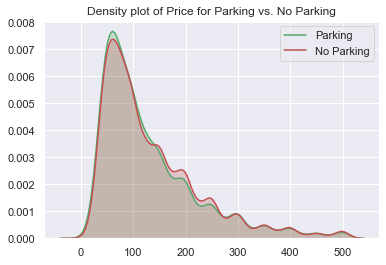

In [34]:
# First, plot parking vs. non-parking prices.
sns.kdeplot(listings.loc[listings['parking'] == 1,'price'],shade = True, label="Parking",color="g")
sns.kdeplot(listings.loc[listings['parking'] == -1,'price'],shade = True, label="No Parking",color="r")
plt.title("Density plot of Price for Parking vs. No Parking");

We saw before that the correlation between price and parking is -0.019383. Since parking is desirable, we expect the price to increase with parking. When we see a pattern like this, we should suspect the existence of **interaction effects** that are complicating the parking vs. price relationship. Interaction effects are when the relationship between two variables is **conditional**, or depends on the value of a third, hidden variable.

What could this third variable potentially be? Well, we have seen that location has a huge impact on prices. Perhaps high-price areas don't have many parking spots, whereas low-price areas do? We don't know this for sure, but it's a worthwhile guess.

More formally, we hypothesize that this observed negative correlation is the result of interaction effects arising from location. In order to investigate this hypothesis, we ought to break down the locations by neighborhood and see if this negative correlation between price and parking still holds within neighborhoods. The neighborhoods are discrete and there are many listings per neighborhood, so we can simply compute the correlation for every neighborhood individually. Mathematically, this is exactly the same thing as conditioning on the neighborhood and computing the conditional correlation.

### Exercise 6:

Read the following piece of code, and explain what the number ```res['Brooklyn']``` means. Then explain the relationship between the histogram and our finding that parking is negatively correlated with price.

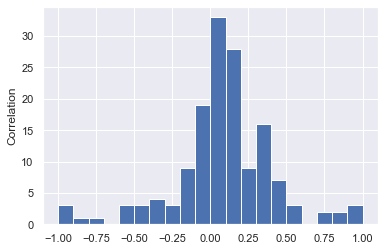

Average correlation:  0.08178058684472027


In [21]:
neighbourhoods = listings.neighbourhood.unique()
cvec = list()
cvec = dict()

for x in neighbourhoods:
    temp = listings[listings['neighbourhood'] == x]
    cvec[x] = temp.corr()['price']['parking']


res = list(cvec.values())
res = [x for x in res if str(x) != 'nan']
res.sort()


plt.hist(res, bins=20)
plt.ylabel('Correlation')
plt.show()


print('Average correlation: ', sum(res)/len(res))
# print(cvec)

#print(list(cvec).sort())

The correlation values of 1 and -1 are presumably due largely to neighborhoods with very few listings, and should essentially be ignored. Viewing the histogram, however, we can see that a clear majority of correlations are at least slightly positive, for an average correlation of 0.08.

In [22]:
cvec

{'Brooklyn': 0.07324985853986331,
 'Harlem': 0.06439927259749706,
 'Manhattan': 0.0014116378206741884,
 'Flatbush': 0.07032276993588919,
 'Clinton Hill': 0.10039090504288772,
 'Hamilton Heights': -0.013513827281271163,
 'Gowanus': 0.14031028261026218,
 'Lefferts Garden': -0.03739996883474221,
 'Greenpoint': 0.05199466347212524,
 'Boerum Hill': 0.2048275980114942,
 'Kew Garden Hills': 0.3131510759799468,
 'Queens': 0.06333545722178238,
 'Upper East Side': -0.029414027430782187,
 'Ditmars / Steinway': -0.06951507964090892,
 'Upper West Side': -0.015107498957511775,
 'The Bronx': 0.1646808791054178,
 'Williamsburg': 0.07512018579537752,
 'East Village': 0.03417231289203759,
 'Park Slope': 0.07910049544148019,
 'Kingsbridge Heights': -0.8976595391518659,
 'Crown Heights': 0.15467839382795065,
 'Bedford-Stuyvesant': 0.09145076879021433,
 'The Rockaways': 0.08435526182625007,
 'Chelsea': 0.017274023766383543,
 'Carroll Gardens': -0.031593394507984034,
 'Gravesend': 0.38070559759710504,
 'Bus

If we plot this by neighborhood for a few neighborhoods, we can see this somewhat positive correlation of parking vs. no parking visually: 

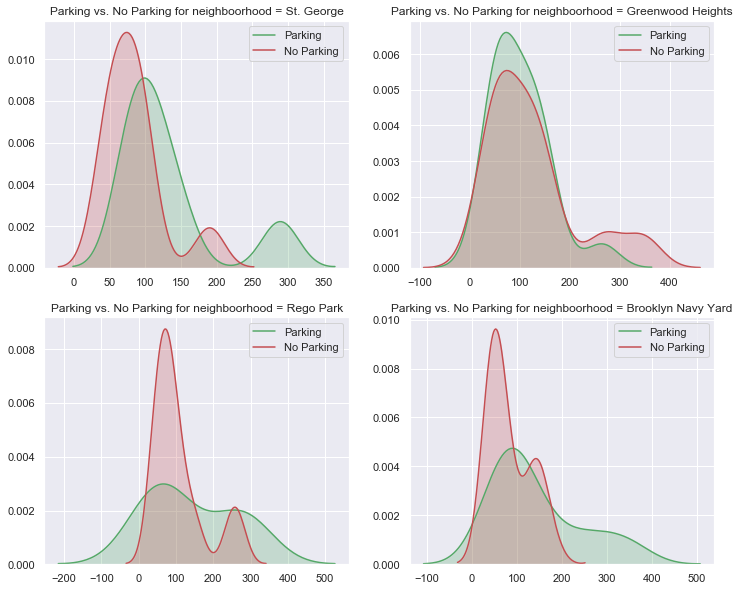

In [23]:
plt.figure(figsize=(12,10))
neigh_to_look = ['St. George','Greenwood Heights','Rego Park','Brooklyn Navy Yard']
for i, neigh in enumerate(neigh_to_look):
 plt.subplot(2,2,i+1)
 sns.kdeplot(listings.loc[(listings['parking'] == 1) & (listings['neighbourhood'] == neigh),'price'],shade = True, label="Parking",color="g")
 sns.kdeplot(listings.loc[(listings['parking'] == -1) & (listings['neighbourhood'] == neigh),'price'],shade = True, label="No Parking",color="r")
 plt.title("Parking vs. No Parking for neighboorhood = " + str(neigh));

As we have seen, the existence of unexpected correlations should spur investigation into potential interaction effects, which lead to potentially interesting hypotheses. Thus, one good way of generating iterative hypotheses is to find and think about potential interaction effects.

### Finding more interactions: how does price vary by property type?

We saw that finding conditional correlations or interactions is a good way to generate further hypotheses, as many interesting lines of investigation arise from investigating these **confounding variables**. Here is another example: let's now look at how price varies with property type. The following code plots the price of a one bedroom listing broken down by the property type:

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 <a list of 32 Text xticklabel objects>)

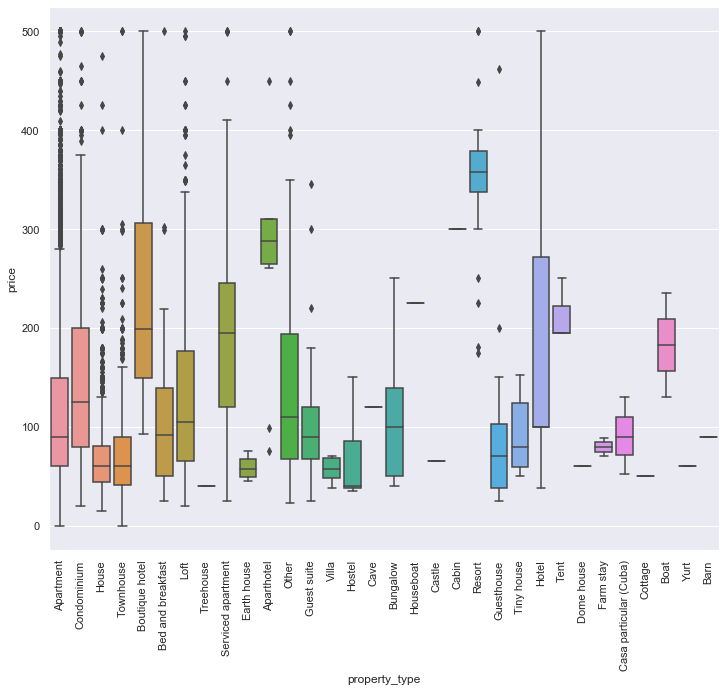

In [24]:
plt.figure(figsize=(12,10)) 
sns.boxplot(y=listings.loc[listings['bedrooms']==1,'price'], x= listings.loc[listings['bedrooms']==1,'property_type'])
plt.xticks(rotation = 90)

### Exercise 7:

#### 7.1

What can you conclude about the variation in price of a one bedroom by the property type?

#### 7.2

Do the same price vs. property type plot for two bedroom listings.

#### 7.3

Pick any other variable of your choice and make another interactive plot, showing the variation of price broken down by sub-categories of that variable.

### More hypothesis generation (10 mts)

So far, we have primarily been interested in understanding what factors influence the price of an existing listing. However, a natural question to ask is what you can do to increase the price of your own listing without spending too much money?

Looking through the list of correlations, two immediately stand out: 

| Object          | Correlation  | 
| :-------------  | :----------: | 
|  AC             | 0.18         | 
|  TV             | 0.26         | 

Some air conditioning is relatively cheap, and has a large correlation of 0.189. Televisions are very cheap, and have an enormous correlation of 0.26. This suggests that one of the best things I can do for a listing is run out and buy a TV if I don't have one – a 300 dollar TV might increase the value of a listing by 30 dollars per night!

### Question:

Do you really believe this could work? Can you come up with any simple plot or explanation that would argue one way or the other?

Apartments with TVs are systematically better than those without – indeed, presence of a television is positively correlated with many other positive price signals, from the size of the listing (e.g. number of people it accommodates) to essentially all other amenities. Nevertheless, it is important to not quickly conclude everything simply based on correlations. We will discuss this much more carefully in a later class on causal inference.

## Exploring temporal effects: summer in Rio and winter in Moscow (10 mts)

We have seen that conditional plots can be a useful way to "correct" comparisons by taking into account interaction effects.

Time is a very common interaction effect that appears across lots of datasets. For Airbnb data, this is especially important, as Airbnb is often more expensive near holidays, and so reasonable price estimates must take this into account. In practice this is one of the most important corrections offered by Airbnb pricing consultancy firms, and corrections usually take advantage of data pooled from many somewhat similar cities. This is vital to achieving good corrections, but it is easy to make mistakes by failing to account for important city-to-city differences.

We begin by opening up the calendar data and counting (i) the number of rentals per day; and (ii) their total prices: 

In [26]:
cal = pd.read_csv('scal.csv', delimiter=',')
cal.head()
# Count rentals and total price on each date.

,date,price
0,20190709,149.0
1,20190709,76.0
2,20190710,76.0
3,20190711,76.0
4,20190712,76.0


In [27]:
rcount = dict()
rprice = dict()

for row in cal.itertuples(index=True, name='Pandas'):
    rcount[str(row[1])] = rcount.get(str(row[1]), 0) + 1
    rprice[str(row[1])] = rprice.get(str(row[1]), 0) + row[2] 

In [28]:
rcount
rprice

{'20190709': 7311122.0,
 '20190710': 7336477.0,
 '20190711': 7364554.0,
 '20190712': 7574463.0,
 '20190713': 7600433.0,
 '20190714': 7374435.0,
 '20190715': 7402541.0,
 '20190716': 7416168.0,
 '20190717': 7420430.0,
 '20190718': 7434145.0,
 '20190719': 7608526.0,
 '20190720': 7633376.0,
 '20190721': 7404288.0,
 '20190722': 7397609.0,
 '20190723': 7430512.0,
 '20190724': 7444154.0,
 '20190725': 7448882.0,
 '20190726': 7639731.0,
 '20190727': 7672200.0,
 '20190728': 7431108.0,
 '20190729': 7428820.0,
 '20190730': 7433812.0,
 '20190731': 7428124.0,
 '20190801': 7464241.0,
 '20190802': 7653010.0,
 '20190803': 7677334.0,
 '20190804': 7469903.0,
 '20190805': 7463023.0,
 '20190806': 7483988.0,
 '20190807': 7488712.0,
 '20190808': 7491771.0,
 '20190809': 7666070.0,
 '20190810': 7685216.0,
 '20190811': 7473277.0,
 '20190812': 7471003.0,
 '20190813': 7478440.0,
 '20190814': 7484016.0,
 '20190815': 7483085.0,
 '20190816': 7660942.0,
 '20190817': 7673251.0,
 '20190818': 7463552.0,
 '20190819': 744

In [29]:
# Next, plot the results. 
tempcount = sorted(rcount.items())
x, y = zip(*tempcount) 
tempprice = sorted(rprice.items())
u,v = zip(*tempprice)

# plt.plot(x, y)
# plt.show()

In [30]:
# Next, we look at average price

tempprice = sorted(rprice.items())
u,v = zip(*tempprice)

ratio = lambda a,b: float(a)/float(b) 

avgprice = list(map(ratio, v,y))

xd = pd.to_datetime(x)


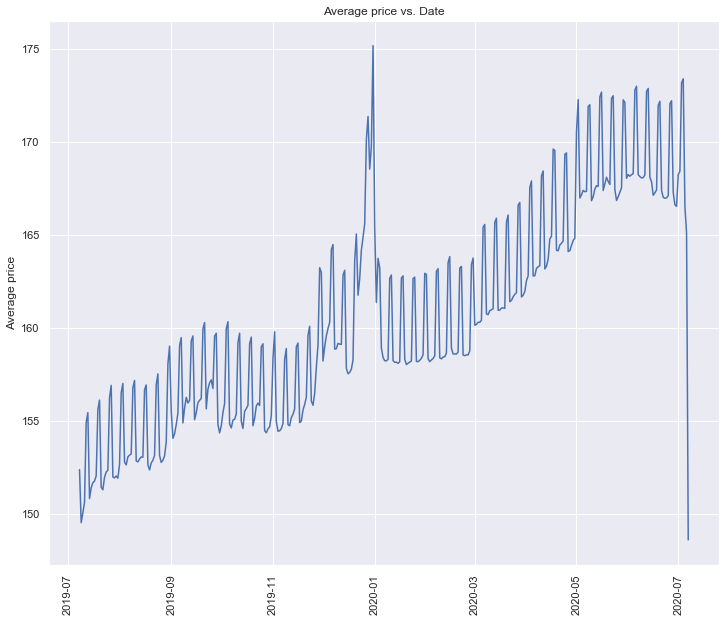

In [31]:
plt.figure(figsize=(12,10))
plt.plot(xd,avgprice)
plt.xticks(rotation = 'vertical')
plt.ylabel('Average price')
plt.title("Average price vs. Date")
plt.show()

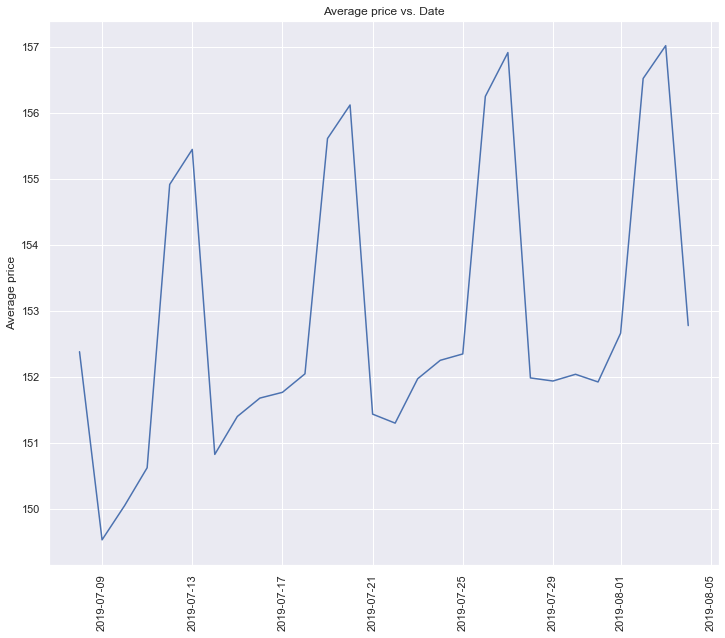

In [32]:
#Let us also plot a smaller time interval
plt.figure(figsize=(12,10))
plt.plot(xd[0:28],avgprice[0:28])
plt.xticks(rotation = 'vertical')
plt.ylabel('Average price')
plt.title("Average price vs. Date")
plt.show()

When analyzing time series data like this, it is common to view it as a sum of several contributing effects over time plus noise. The two common types of summands in such a representation are:

1. **Seasonal effects**: this is a summand that is periodic, often with period corresponding to the calendar (week, month or year).
2. **Trend effects**: this is a smooth summand that goes up or down slowly over an entire series, representing long-term trends such as price inflation.

### Exercise 8:

#### 8.1

Visually, can you see any strong seasonal or trend components? What do they mean?

#### 8.2

What is the enormous spike that you see in this chart? Is it real, and how would you describe what is going on in layman's terms?


#### 8.3

Can we guess the busiest season (excluding Christmas) from this raw chart?

This brings us to an important topic: bringing in auxiliary datasets! The Inside Airbnb website includes calendar data for many cities, and we can use these to adjust for the trend component. To get some diversity, we should make sure to source some data from: (i) a city close to NYC; (ii) a city in the US with very different weather; and (iii) some cities very far away.

## Conclusions (10 mts)

In this case, we saw that Airbnb prices are influenced by many factors. Some of the main ones include location, date, number of bedrooms, number of guests, and property type.

Any future model we build should feature these factors. Incorporating some of these factors, such as the number of bedrooms, should be straightforward, as this has a large and nearly linear relationship to price. But others, such as location, exhibit very non-linear relationships. We will learn how to deal with these types of complex relationships in future cases.

We also found some surprising correlations, such as the negative correlation between price and parking. However, after breaking the data down by neighborhoods and incorporating the interaction effect of location, this negative correlation went away entirely.

Temporal effects are a very specific type of interaction effect which must be dealt with separately. Our exploration tells us that any model of AirBnB pricing should take into account strong seasonal components as well as strong spikes around major holidays. 

## Takeaways (5 mts)
In this case, you learned the following exploration process:

1. Start by looking at marginal distributions of quantities of interest to look for interesting patterns and/or outliers.
2. A correlation matrix can quickly reveal the most promising candidate variables for further investigation.
3. Investigate each of these candidate variables in turn. Note which ones exhibit interesting and unexpected correlations.
4. Explore potential interaction effects for the variables with unexpected correlations. Suspected important interactions should be looked at directly with further plotting.
5. Finally, take some time to carefully plot any interactions that you know to be important from domain knowledge. In our case, we looked at two features that are common to many datasets: location data and temporal data. Both of these contained very important signals that were immediately visually apparent, but which were strongly non-linear and could not easily be reduced to correlations or other simple summaries.

This process can be a bit daunting at first, but it is widely used by veteran data analysts and scientists and is extremely effective in most situations. By iteratively generating hypotheses throughout this process and investigating them, you can uncover great insight about what is going on without building a single formal model. Formal modelling will be discussed in future cases.